## Setup

In [58]:
# imports
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os
import time

from kpca.utils import *
from kpca.kernel_pca import KernelPCA
from kpca.data import Loader, mnist

# ipython
%matplotlib inline 
%load_ext autoreload
%autoreload 2

# cuda
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

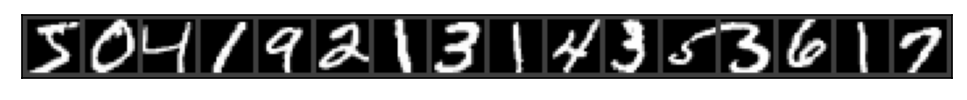

In [9]:
x1,l1,x2,l2,x3,l3 = mnist('cuda')[:6]
x = torch.cat([x1,x2,x3]) # concat train, val, test
x = x[:,:,4:-4,4:-4].contiguous() # crop borders
x = tovec(x) # convert to vec
x /= x.std() # normalize
show_grid(toim(x)[:16],nrow=16)

## Train

In [86]:
# seed 
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)

In [87]:
loader = Loader(x,batch_size=64).__iter__()
net = KernelPCA(m=400, n=800, kernel='cos', d=1, lam=1e-3, device='cuda')
info = None

In [88]:
# warmup period
info = net.train(loader,etaq=0.0,etaw=0.01,etal=.1,n_iter=1000,print_iter=10)

0/1000: e=70050.8359, t=0.0175
100/1000: e=-3853.5742, t=1.3701
200/1000: e=56629.4336, t=2.5162
300/1000: e=171749.2188, t=3.6919
400/1000: e=365157.7500, t=4.8552
500/1000: e=665753.6250, t=6.0046
600/1000: e=981135.3750, t=7.1320
700/1000: e=1253018.3750, t=8.2569
800/1000: e=1359122.8750, t=9.4217
900/1000: e=1421539.2500, t=10.5400


In [91]:
# training 
net.d = 1
info = net.train(loader,etaq=0.0,etaw=.001,etal=0.01,n_iter=10000,print_iter=10,info=info)

0/10000: e=1473779.1250, t=0.0178
1000/10000: e=20243.6035, t=12.2232
2000/10000: e=18406.5547, t=26.5850
3000/10000: e=15778.6680, t=41.1463
4000/10000: e=19203.0176, t=55.4315
5000/10000: e=16591.3770, t=66.3600
6000/10000: e=16500.2285, t=78.0985
7000/10000: e=20074.7871, t=89.7980
8000/10000: e=16498.6055, t=101.4554
9000/10000: e=21434.9727, t=112.7215


In [94]:
info = net.train(loader,etaq=0.0,etaw=.0001,etal=0.001,n_iter=10000,print_iter=10,info=info)

0/10000: e=18050.5059, t=0.0262
1000/10000: e=15843.6445, t=11.4449
2000/10000: e=19169.0273, t=22.6430
3000/10000: e=13470.5762, t=33.8008
4000/10000: e=16881.9629, t=45.0545
5000/10000: e=16635.0742, t=56.2888
6000/10000: e=17529.7988, t=67.6605
7000/10000: e=19798.6172, t=79.0066
8000/10000: e=17199.6641, t=90.2126
9000/10000: e=15657.0088, t=101.3348


## Save Figures

In [83]:
MODEL_PATH = './trained-nets/mnist-d_1.pt'
torch.save(net.state_dict(), MODEL_PATH)

## Training evaluation

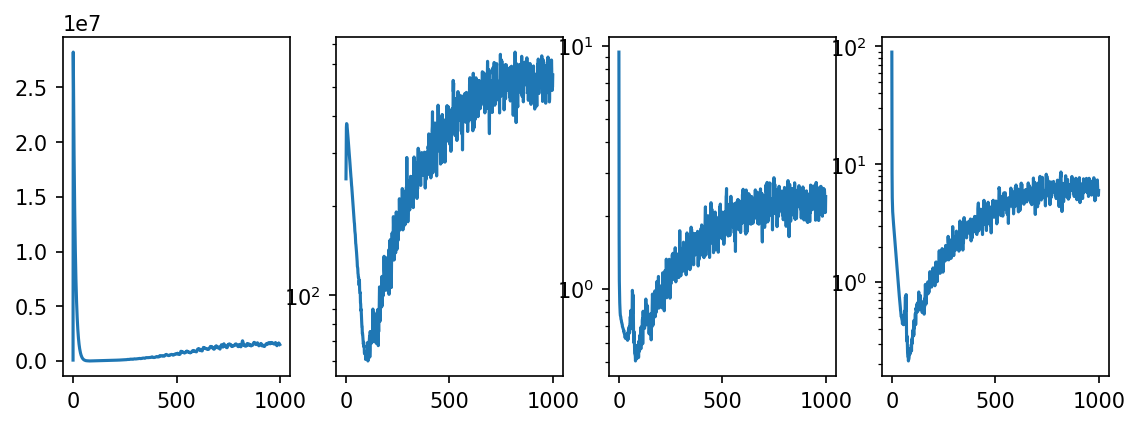

In [89]:
plt.figure(figsize=(9,3),dpi=150)
plt.subplot(141)
plt.plot(info['es'])

plt.subplot(142)
plt.plot(info['gqs'])
plt.yscale('log')

plt.subplot(143)
plt.plot(info['gws'])
plt.yscale('log')

plt.subplot(144)
plt.plot(info['gls'])
plt.yscale('log')

## Visualize the results

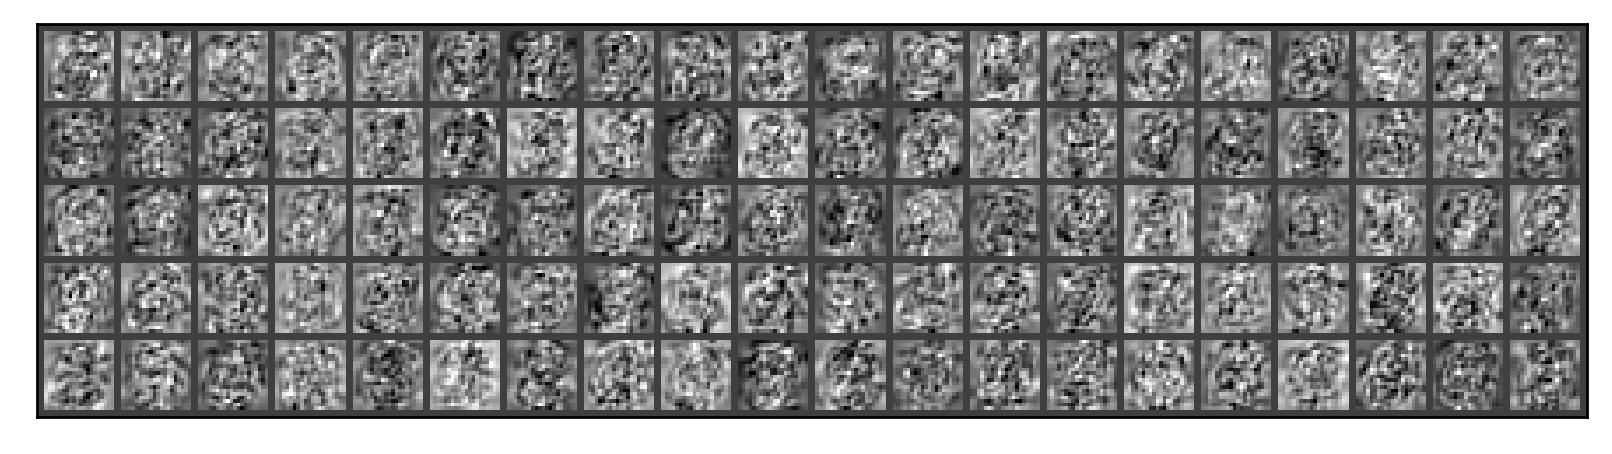

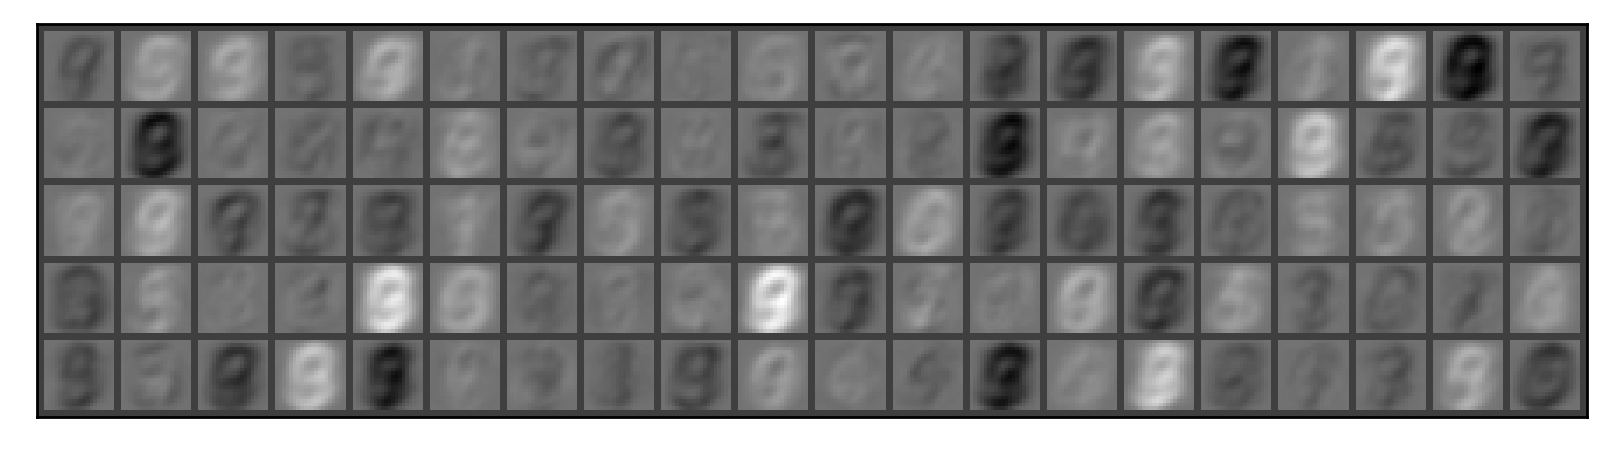

In [90]:
y = net(x)
wf = sta(x,y,1e-1)
show_grid(toim(wf[:100]),nrow=20, dpi=250, norm_every=True)
show_grid(toim(net.w[:100]),nrow=20,dpi=250, norm_every=False)